In [1]:
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import Planck18
from astropy.coordinates import SkyCoord
from matplotlib.patches import Ellipse
from astropy.table import Table
from astroquery.ipac.ned import Ned
from astroquery.vizier import Vizier

import ztfidr
import galaxy_phot as glp

warnings.filterwarnings('ignore')

In [2]:
importlib.reload(glp)
sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

conds1 = (sample.data['redshift'] > 0 ) & (sample.data['redshift'] < 0.2) 
conds2 = np.intersect1d(host_data.index, sample.data.index)
data = host_data[['host_ra', 'host_dec']].loc[conds2].dropna()[conds1]
targets = data.index
len(data)

3613

In [3]:
df3 = pd.read_csv('csv_files/dr2_run3_g.csv', index_col=1).drop('index', axis=1)
df3_r = df3[(df3['a_leg'] != 0) & (df3['a_ps1'] != 0)  & (df3['chi2_leg'] < 1.5) 
            & (df3['chi2_ps1'] < 1.5) & (df3['a_leg'] > df3['a_ps1']*0.9)]

df4 = pd.read_csv('csv_files/dr2_run4_g.csv', index_col=1).drop('index', axis=1)
df4_r = df4[(df4['a_leg'] != 0) & (df4['a_ps1'] != 0)  & (df4['chi2_leg'] < 1.5) 
            & (df4['chi2_ps1'] < 1.5) & (df4['a_leg'] > df4['a_ps1']*0.8)]

df5 = pd.read_csv('csv_files/dr2_run5_g.csv', index_col=1).drop('index', axis=1)
df5_r = df5[(df5['a_leg'] != 0) & (df5['a_ps1'] != 0)  & (df5['chi2_leg'] < 1.5) 
            & (df5['chi2_ps1'] < 1.5) & (df5['a_leg'] > df5['a_ps1']*0.8)]


len(df3_r), len(df4_r), len(df5_r)

(663, 830, 773)

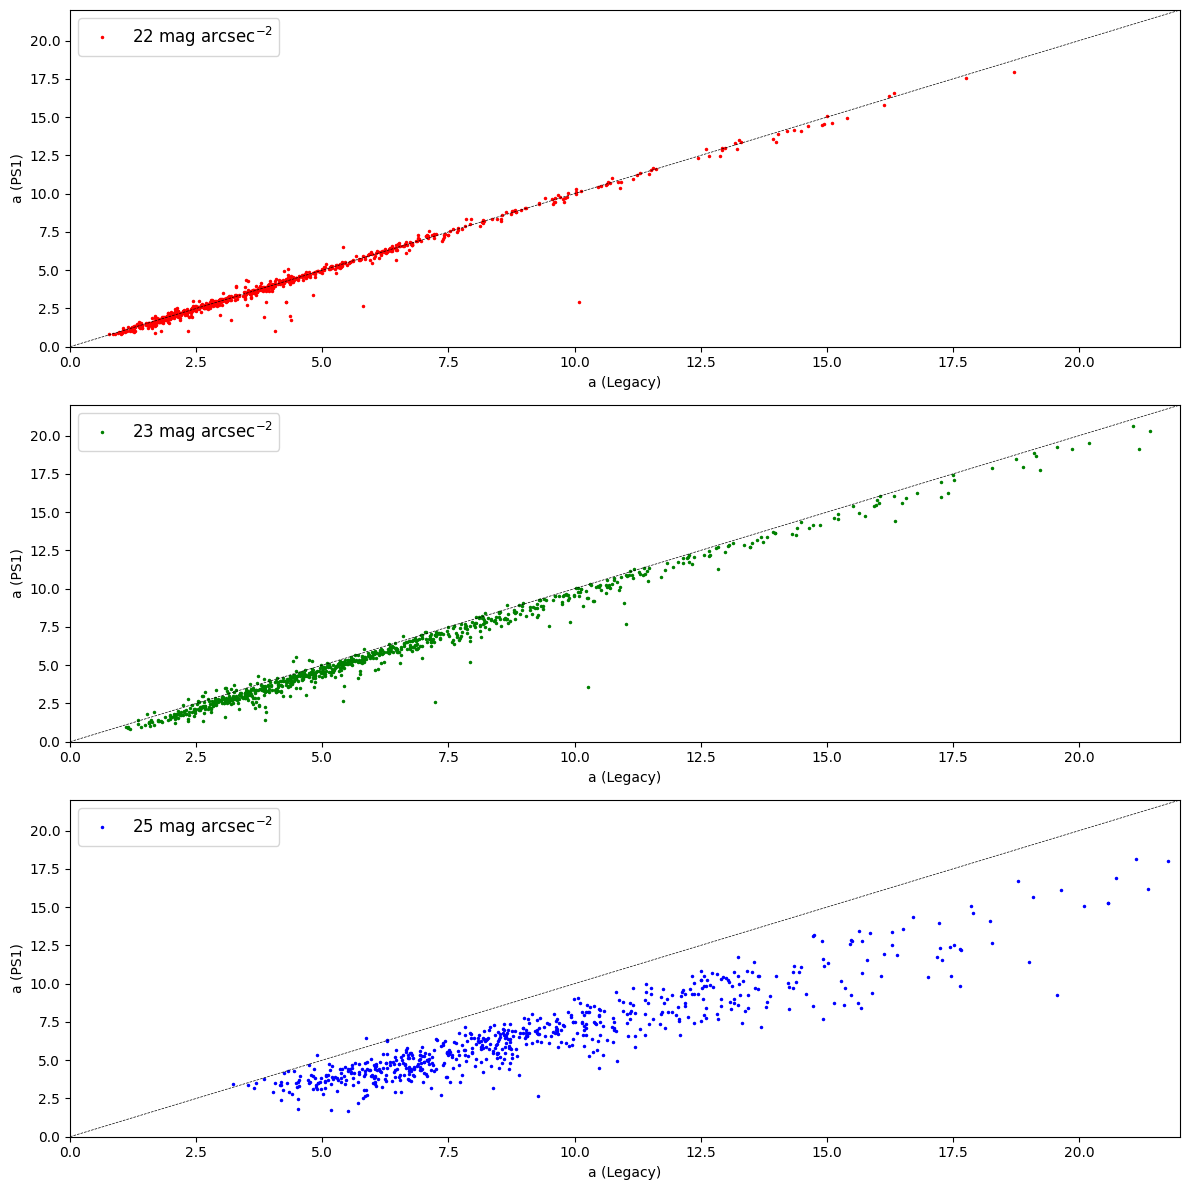

In [4]:
fig, axis = plt.subplots(nrows=3, figsize=(12, 12), dpi=100)
axis[0].plot(df5_r['a_leg'], df5_r['a_ps1'], 'r.', ms=3, label='22 mag arcsec$^{-2}$')
axis[1].plot(df4_r['a_leg'], df4_r['a_ps1'], 'g.', ms=3, label='23 mag arcsec$^{-2}$')
axis[2].plot(df3_r['a_leg'], df3_r['a_ps1'], 'b.', ms=3, label='25 mag arcsec$^{-2}$')

x = np.linspace(0, 25)
for ax in axis:
    ax.set_ylabel('a (PS1)')
    ax.set_xlabel('a (Legacy)')
    ax.legend(fontsize=12)
    ax.plot(x, x, 'k--', lw=0.5)
    ax.set_xlim([0, 22])
    ax.set_ylim([0, 22])


plt.tight_layout()

In [ ]:
df10 = Table.read('fits_files/survey-bricks-dr10-south.fits.gz', format='fits')
ra10, dec10 = df10[['ra', 'dec']].to_pandas().values.T

df9 = Table.read('fits_files/survey-bricks-dr9-north.fits.gz', format='fits')
ra9, dec9 = df9[['ra', 'dec']].to_pandas().values.T

ra_f = np.concatenate([ra10, ra9])
dec_f = np.concatenate([dec10, dec9])
nearest_cell = []
for i, (ra_i, dec_i) in enumerate(zip(data['sn_ra'], data['sn_dec'])):
    dist = np.sqrt((ra_i-ra_f)**2 + (dec_i-dec_f)**2)
    nearest_cell.append(np.min(dist))

nc = np.array(nearest_cell)

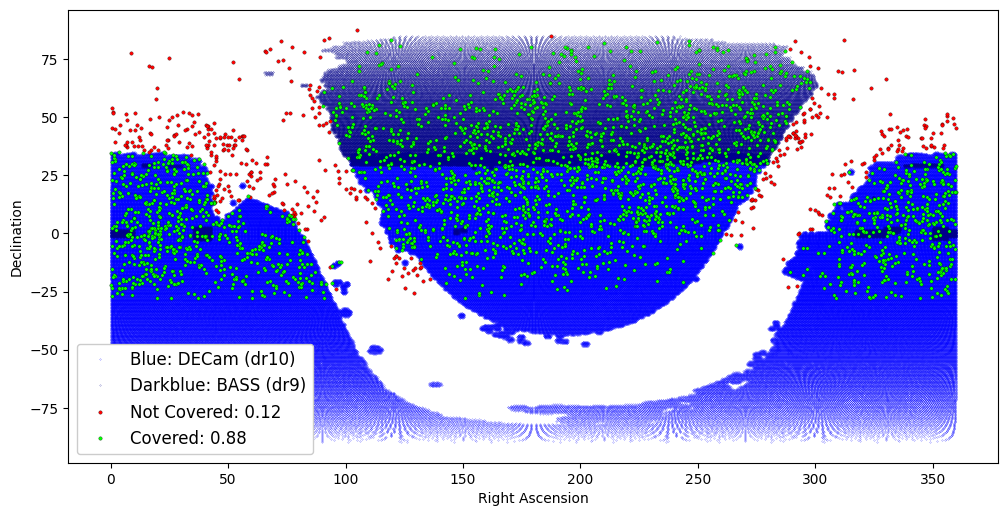

In [9]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
ax.plot(ra10, dec10, 'b.', ms=0.3, label='Blue: DECam (dr10)')
ax.plot(ra9, dec9, 'g.', ms=0.3, color='darkblue', label='Darkblue: BASS (dr9)')

covered = (nc <= 0.7)
label_cov = f'Covered: {np.sum(covered)/len(nc):.2f}'
label_ncov = f'Not Covered: {1-np.sum(covered)/len(nc):.2f}'
ax.plot(data['sn_ra'][~covered], data['sn_dec'][~covered], 'r.', ms=5,  mec='black', mew=0.2, label=label_ncov)
ax.plot(data['sn_ra'][covered], data['sn_dec'][covered], 'r.', ms=5, color='lime', mec='black', mew=0.2, label=label_cov)
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')
ax.legend(loc=3, framealpha=1, fontsize=12)

In [3]:
sn_name = 'ZTF19acihlft' 
gobj_leg = glp.HostGal(verbose=True)
gobj_leg.init_dr2(sn_name, sample, host_data)
gobj_leg.get_image(source='save', survey='auto', output_='z', band='g', scale=0.262)

gobj_ps1 = glp.HostGal(verbose=True)
gobj_ps1.init_dr2(sn_name, sample, host_data)
gobj_ps1.get_image(source='save', survey='ps1', output_='z', band='g', scale=0.25)


ZTF19acihlft 325.97262 -10.183639999999999 0.02
legacy 700 0.262
ZTF19acihlft 325.97262 -10.183639999999999 0.02
ps1 917 0.25


In [4]:
mag_r = np.arange(20.0, 25.05, 0.1)
cr_leg = np.zeros((len(mag_r), 5))
cr_ps1 = np.zeros((len(mag_r), 5))
for i, iso_i in enumerate(mag_r):
    gobj_leg.fit_isophote(iso_i, plot=False)
    pars1 = gobj_leg.iso
    (xc, yc), a, b, theta = pars1['center'][0], pars1['a'][0], pars1['b'][0], pars1['angle'][0]
    cr_leg[i] = [xc, yc, a, b, theta]

    gobj_ps1.fit_isophote(iso_i, plot=False)
    pars2 = gobj_ps1.iso
    (xc, yc), a, b, theta = pars2['center'][0], pars2['a'][0], pars2['b'][0], pars2['angle'][0]
    cr_ps1[i] = [xc, yc, a, b, theta]

In [34]:
def ellipse_para(theta, xc, yc, a, b, pa):
    x = a*np.cos(theta)*np.cos(pa) - b*np.sin(theta)*np.sin(pa) + xc
    y = a*np.cos(theta)*np.sin(pa) + b*np.sin(theta)*np.cos(pa) + yc
    return x, y

def plot_contours(gobj, cr_arr, ax, lims, label):
    mag = gobj.cutout['mag']
    ax.imshow(mag, cmap='gray')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(label)

    for row_i in cr_arr[::-4]:
        xci, yci, ai, bi, thetai = row_i
        ell_patchi = Ellipse((xci, yci), 2*ai, 2*bi, np.rad2deg(thetai), edgecolor='lime', facecolor='none', lw=1)
        ax.add_patch(ell_patchi)

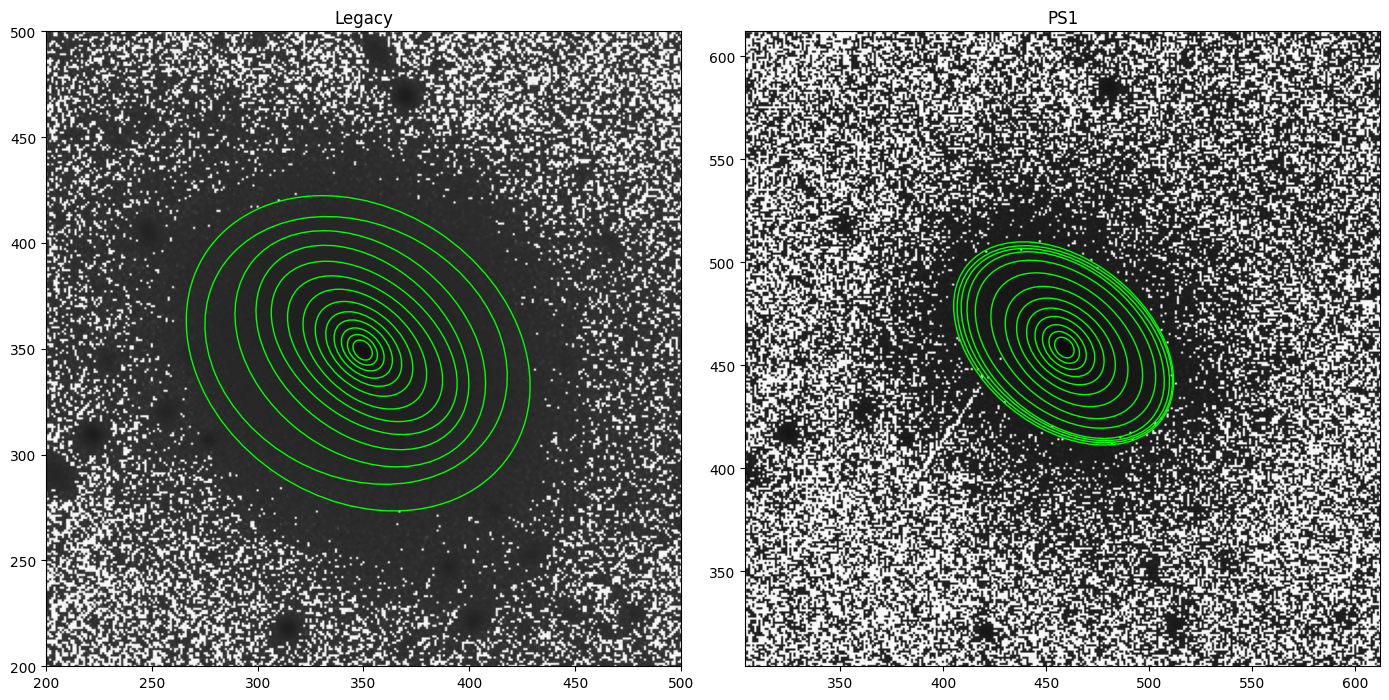

In [35]:
fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=(14, 7), dpi=100)
plot_contours(gobj_leg, cr_leg, ax1, [200, 500], 'Legacy')
plot_contours(gobj_ps1, cr_ps1, ax2, [304, 612], 'PS1')
plt.tight_layout()

In [14]:
def tagret_angle(ang, cr_arr):
    target_ang = np.zeros(len(cr_arr))
    theta_ref = cr_arr[-1][4]
    for i, row_i in enumerate(cr_arr):
        xci, yci, ai, bi, thetai = row_i
        ep = ellipse_para(ang + (theta_ref - thetai),  xci, yci, ai, bi, thetai)
        target_ang[i] = np.sqrt((ep[0]-xci)**2 + (ep[1]-yci)**2)
    return np.array(target_ang)

def bulge(x, a, h, n):
    return a + 2.5*(x/h)**(1/n)

def disk(x, a, h):
    return a + 2.5*(x/h)

def add_mag(m1, m2):
    return -2.5*np.log10(10**(-0.4*m1) + 10**(-0.4*m2))

def combine(x, a_b, a_d, h_b, h_d, n):
    return add_mag(bulge(x, a_b, h_b, 4), disk(x, a_d, h_d))

targ_leg = tagret_angle(0, cr_leg) * 0.262
targ_ps1 = tagret_angle(0, cr_ps1) * 0.25

def plot_decomp(x, y, lim, ax, survey):
    cuts = y < lim
    fit_pars = curve_fit(combine, x[cuts], y[cuts], p0=[19, 20, 30, 30, 4])
    x_new = np.linspace(1, np.max(x), 100)
    ax.plot(x[cuts], y[cuts], 'k.', label='> 5 $\sigma$')
    ax.plot(x[~cuts], y[~cuts], 'r.', label='< 5 $\sigma$',  marker='x', c='lime')
    ax.set_title(f'{survey}, limit: {lim} mag')
    ax.plot(x_new, combine(x_new, *fit_pars[0]), 'r-', label='combined')
    a_b, a_d, h_b, h_d, n = fit_pars[0]
    ax.plot(x_new, bulge(x_new, a_b, h_b, n), 'g--', label='bulge')
    ax.plot(x_new, disk(x_new, a_d, h_d), 'b--', label='disk')
    ax.set_ylim([19.5, 25.5])
    ax.set_xlim([0, 23])

    ax.invert_yaxis()
    ax.legend(fontsize=12)
    ax.set_xlabel('R [kpc]', fontsize=12)
    ax.set_ylabel('$\mu \:[mag\:arcsec^{-1}]$', fontsize=12)
    return fit_pars

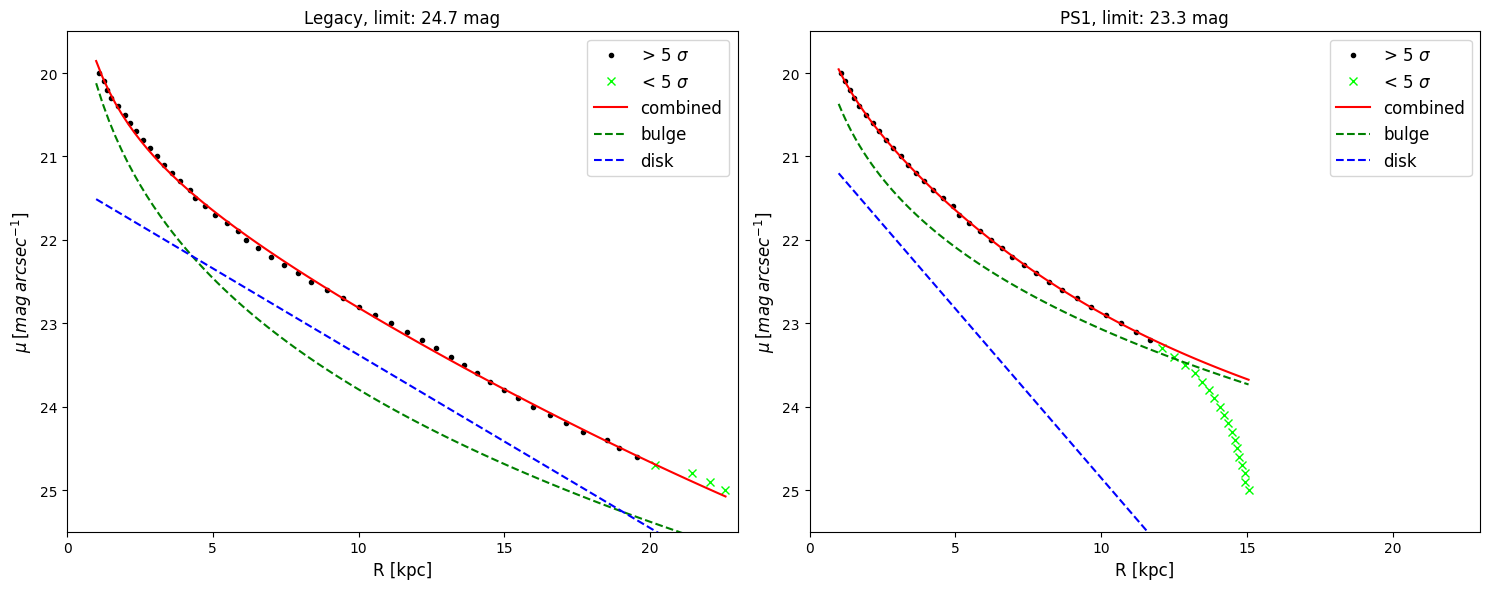

In [92]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 6), ncols=2, dpi=100)
out_leg = plot_decomp(targ_leg, mag_r, 24.7, ax1, 'Legacy')
out_ps1 = plot_decomp(targ_ps1, mag_r, 23.3, ax2, 'PS1')
plt.tight_layout()

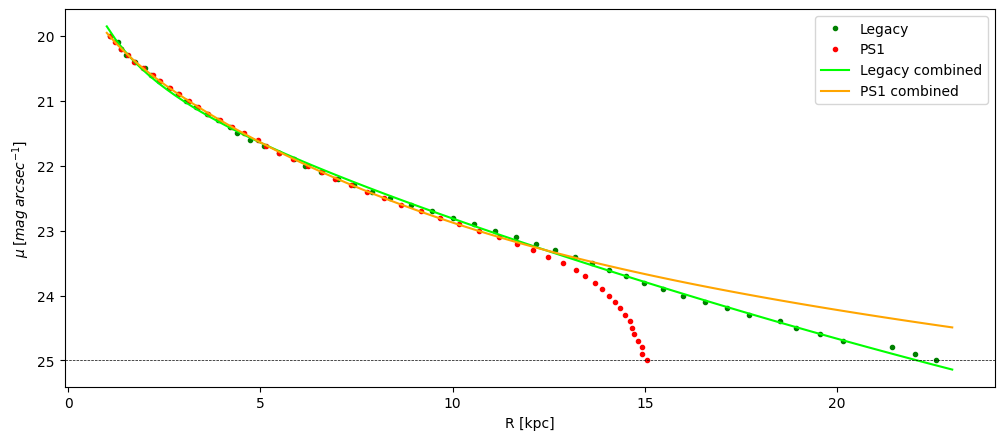

In [93]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
x_new = np.linspace(1, 23, 100)
ax.plot(targ_leg, mag_r, 'g.', label='Legacy')
ax.plot(targ_ps1, mag_r, 'r.', label='PS1')

ax.plot(x_new, combine(x_new, *out_leg[0]), 'g-', label='Legacy combined', c='lime')
ax.plot(x_new, combine(x_new, *out_ps1[0]), 'r-', label='PS1 combined', c='orange')

ax.invert_yaxis()
ax.legend(fontsize=10)
ax.set_xlabel('R [kpc]', fontsize=10)
ax.set_ylabel('$\mu \:[mag\:arcsec^{-1}]$', fontsize=10)
ax.axhline(25, c='black',ls='--', lw=0.5)

VCC:          Galaxy name from the VCC catalog
Q:            Quality of fit
m_tot_:       Total flux, extrapolated to infinity [mag]
ell_d_:       Disk ellipticity
B_T:          Bulge to total ratio (meta.note)
C28:          Galaxy light concentration, 5log10(r80/r20)
mu50:         Effective surface brightness [mag/arcsec2]
r50: 	      Effective radius [arcsec] (50% of total light)
mu_d_:        Effective SB of disk [mag/arcsec2]
r_d_:         Effective radius of disk [arcsec]
mu_b_:        Effective SB of bulge [mag/arcsec2]
r_b_:         Effective radius of bulge [arcsec]
n_b_:         Sersic index n for bulge
m_n_:         Total flux of nucleus [mag]
FWHM:         Moffat seeing width [arcsec]

In [6]:
Vizier.ROW_LIMIT = 1000
q1 = Vizier.get_catalogs('VII/266/bdd_g') # Atlas of Virgo galaxies (McDonald+ 2011) # 285
q1[0].show_in_notebook()

idx,VCC,Q,m_tot_,ell_d_,B_T,C28,mu50,r50,mu_d_,r_d_,mu_b_,r_b_,n_b_,m_n_,FWHM
,,,mag,,,,mag / arcsec2,arcsec,mag / arcsec2,arcsec,mag / arcsec2,arcsec,,mag,arcsec
0,0355,3,12.00,0.122,0.554,5.347,20.77,11.02,22.63,27.14,19.04,5.01,2.000,16.65,1.49
1,0389,3,13.78,0.201,0.181,3.787,23.29,19.17,23.60,26.38,21.89,6.37,1.100,17.34,1.04
2,0437,3,13.65,0.456,0.208,3.904,24.52,35.63,24.78,56.98,23.09,14.08,1.300,17.35,1.17
3,0459,3,14.92,0.418,0.383,3.230,22.15,7.48,23.01,11.70,21.15,4.73,0.800,19.36,1.27
4,0483,1,11.33,0.481,0.006,3.419,22.88,54.84,22.40,54.06,--,1.00,--,15.20,2.22
5,0490,3,13.44,0.183,0.278,3.763,24.22,33.73,26.04,83.39,23.09,18.65,0.800,16.35,1.57
6,0497,3,11.93,0.865,0.127,3.247,25.14,130.40,24.07,180.70,24.46,83.90,1.600,20.03,1.52
7,0510,3,14.81,0.205,0.121,3.210,24.50,22.68,24.77,29.56,23.92,8.40,1.000,18.17,1.16
8,0522,3,12.97,0.494,0.298,3.353,23.28,32.47,24.11,49.13,23.22,19.80,3.000,21.91,1.36


In [7]:
q2 = Vizier.get_catalogs('VII/237/pgc') # Catalog of Principal Galaxies  (Paturel+, 2003) , 983k
q2[0].show_in_notebook() # 25mag, a/b

idx,PGC,RAJ2000,DEJ2000,OType,MType,logD25,logR25,PA,ANames
,,,,,,log(0.1arcmin),,deg,
0,2402729,00 00 00.1,+51 55 15,G,,0.38,0.10,126.0,
1,520795,00 00 00.1,-45 57 15,G,,0.53,0.18,22.0,
2,1961515,00 00 00.1,+31 43 54,G,,0.60,0.21,160.0,
3,1982072,00 00 00.1,+32 08 12,G,,0.51,0.13,136.0,
4,535833,00 00 00.1,-44 34 41,G,,0.53,0.23,148.0,
5,622563,00 00 00.1,-37 28 35,G,,0.47,0.12,136.0,
6,124374,00 00 00.2,-41 25 22,G,,0.57,0.04,--,LCRSB235726.1-414205
7,2794824,00 00 00.2,-40 06 48,G,,--,--,--,
8,398935,00 00 00.4,-56 35 19,G,,0.43,0.21,16.0,


In [9]:
q1 = Vizier.get_catalogs('J/ApJS/186/427') # Detailed morphology of SDSS galaxies (Nair+, 2010) 14k
q1[0].show_in_notebook() # T, n, b/a, mass, sfr

idx,SDSS,zs,g_mag,r_mag,log_M_,Age,b_a,sigma,TT,_RA,_DE
,,,mag,mag,log(solMass),Gyr,,km / s,,deg,deg
0,J155341.74-003422.84,0.078,15.820,15.058,11.083,4.459,0.794,143.680,3,238.42392,-0.573011
1,J155146.83-000618.62,0.055,15.512,14.606,11.245,7.111,0.954,204.810,-5,237.94512,-0.105172
2,J154453.22+002415.48,0.034,15.631,14.838,10.405,4.287,0.848,129.970,-2,236.22175,0.404300
3,J154711.32+002424.81,0.033,15.716,15.158,10.156,1.901,0.854,45.250,4,236.79717,0.406892
4,J154514.39+004619.89,0.013,15.341,14.956,9.173,1.891,0.329,89.320,5,236.30996,0.772192
5,J155255.43+004304.87,0.033,15.860,15.084,10.484,6.842,0.760,188.820,-5,238.23096,0.718019
6,J155357.40+004117.11,0.039,15.784,15.147,10.627,2.004,0.486,102.610,1,238.48917,0.688086
7,J110122.00-010824.89,0.074,15.588,14.628,11.442,7.491,0.755,285.780,-5,165.34167,-1.140247
8,J112000.06-010711.96,0.025,15.970,15.892,9.119,0.503,0.562,40.340,--,170.00025,-1.119989


In [ ]:
# Vizier.query_object(sn_name, catalog=['HyperLeda']), 
# Vizier.query_region("3C 273", radius=Angle(0.1, "deg"), catalog='GSC')

In [12]:
# sn_name = 'ZTF19abmpoxa'
# gobj = glp.HostGal(verbose=True)
# gobj.init_dr2(sn_name, sample, host_data)
# loc_i = SkyCoord(gobj.gal['host'][0], gobj.gal['host'][1], unit='deg')
# host_query = Vizier.query_object(sn_name, catalog=['HyperLeda'])
# host_name = f"PGC{host_query[0]['PGC'][0]}"
# host_name, sn_name
# q3 = Vizier.query_object(host_name, catalog=[ 'V/154/sdss16'])
# sdss_name = q3[0][0]['SDSS16'].split()[-1]
# q4 = Vizier.query_object(sdss_name, catalog=['J/ApJS/186/427'])